Why does Tokyo have low review scores in the "location" category?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
city_names = ["tokyo", "sydney", "melbourne", "singapore", "hongkong", "taipei", "bangkok"]

In [3]:
cities_df = dict()
for city in city_names:
    cities_df[city] = pd.read_csv("./data/listings_{c}.csv".format(c=city))

In [4]:
reviews_df = dict()
for city in city_names:
    reviews_df[city] = pd.read_csv("./data/reviews_{c}.csv".format(c=city))

In [5]:
df_full_tokyo = pd.merge(cities_df["tokyo"], reviews_df["tokyo"], left_on='id', right_on='listing_id')

df_full_tokyo['all_reviews'] = df_full_tokyo.apply(lambda row: f"Score: {row['review_scores_location']}<br>Review: {row['comments']}", axis=1)

# This step concatenates all reviews and scores for each listing into a single string.
df_full_tokyo['all_reviews'] = df_full_tokyo.groupby('listing_id')['all_reviews'].transform(lambda x: '<br><br>'.join(x))

# Drop duplicate listings, keeping only the first entry (which now contains all reviews and scores)
df_full = df_full_tokyo.drop_duplicates(subset='listing_id')


## Plotting the location in a geographical map

Plotting the location of listings that have top 85% review scores and bottom 10% review scores

In [7]:
import folium

tokyo_coords = [35.682839, 139.759455]

m = folium.Map(location=tokyo_coords, zoom_start=12)


quantile_25 = df_full['review_scores_location'].quantile(0.10) # Too many reviews below 5%, so we use 3% quantile
quantile_75 = df_full['review_scores_location'].quantile(0.85) # No reviews above 90%, so we use 85% quantile

# Plot each point on the map
for idx, row in df_full.iterrows():
    if row['review_scores_location'] < quantile_25:
        color = 'blue'
    elif row['review_scores_location'] > quantile_75:
        color = 'green'
    else:
        continue

    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)

    marker.add_child(folium.Popup(row['all_reviews'], max_width=300))  # adjust max_width to your preference
    marker.add_to(m)

m.save('./map/bad_and_good_location_{c}.html'.format(c="tokyo"))
print("Map saved to 'bad_and_good_location_tokyo.html'. Open it in your browser to view the map.")

Map saved to 'bad_and_good_location_tokyo.html'. Open it in your browser to view the map.


Plot all the location of listings in Tokyo.
Red color for scores above the median, blue color for scores below the median.

In [9]:
import numpy as np

df_sampled = df_full.copy()

quantile_50 = df_sampled['review_scores_location'].quantile(0.50)

m = folium.Map(location=[35.6895, 139.6917], zoom_start=12)

df_sampled['deviation'] = df_sampled['review_scores_location'] - quantile_50

def determine_color(deviation):
    if deviation is None or np.isnan(deviation):
        return "#ffffff"
    # Use logarithmic scaling to emphasize the deviation
    scaled_deviation = np.sign(deviation) * np.log1p(abs(deviation))

    if scaled_deviation > 0:
        # Red color for scores above the median
        intensity = int(255 * (1 - scaled_deviation))
        return f"#{255:02x}{intensity:02x}{intensity:02x}"
    else:
        # Blue color for scores below the median
        intensity = int(255 * (1 + scaled_deviation))
        return f"#{intensity:02x}{intensity:02x}ff"


# Plot each point on the map using the sampled dataframe
for idx, row in df_sampled.iterrows():
    color = determine_color(row['deviation'])
    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)
    marker.add_to(m)

m.save('./map/location_scores_heatmap_tokyo_sampled.html')
print("Map saved to 'location_scores_heatmap_tokyo_sampled.html'. Open it in your browser to view the map.")


Map saved to 'location_scores_heatmap_tokyo_sampled.html'. Open it in your browser to view the map.


In [ ]:
tokyo_coords = [35.682839, 139.759455]

m = folium.Map(location=tokyo_coords, zoom_start=12)


quantile_25 = df_full['review_scores_location'].quantile(0.10) # Too many reviews below 5%, so we use 3% quantile
quantile_75 = df_full['review_scores_location'].quantile(0.85) # No reviews above 90%, so we use 85% quantile

# Plot each point on the map
for idx, row in df_full.iterrows():
    if row['review_scores_location'] < quantile_25:
        color = 'blue'
    elif row['review_scores_location'] > quantile_75:
        color = 'green'
    else:
        continue

    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)

    marker.add_child(folium.Popup(row['all_reviews'], max_width=300))  # adjust max_width to your preference
    marker.add_to(m)

m.save('./map/bad_and_good_location_{c}.html'.format(c="tokyo"))
print("Map saved to 'bad_and_good_location_tokyo_with_comments.html'. Open it in your browser to view the map.")

### Relation between location and neighbourhood

I created a table of average location scores for each neighbourhood.
The table is sorted by the average location score.

It seems that the neighbourhoods with the highest average location can be classified into to groups:
1. Those located in nature, far from the city center. For example, "Fussa Shi" and "Ome Shi" are located in the mountains.
2. Those located in luxury areas. For example, "Minato Ku", "Chiyoda Ku", "Chuo Ku" are business districts, and "Setagaya Ku" is a residential area with many expensive houses.

The neighbourhoods with the lowest average location score are mostly located in residential but not the best nature areas.

In [13]:
neighbourhood_scores = df_full_tokyo.groupby('neighbourhood_cleansed')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)

print("Top 10 neighbourhoods with the highest average location score:")
print(neighbourhood_scores_sorted.head(10))

print("\nBottom 10 neighbourhoods with the lowest average location score:")
print(neighbourhood_scores_sorted.tail(10).sort_values('review_scores_location', ascending=True))

Top 10 neighbourhoods with the highest average location score:
  neighbourhood_cleansed  review_scores_location
0              Fussa Shi                4.966265
1              Minato Ku                4.809081
2                Ome Shi                4.795043
3            Setagaya Ku                4.777035
4             Chiyoda Ku                4.776826
5              Chofu Shi                4.756662
6            Koganei Shi                4.754881
7             Shibuya Ku                4.749732
8                Chuo Ku                4.744929
9            Shinjuku Ku                4.744700

Bottom 10 neighbourhoods with the lowest average location score:
   neighbourhood_cleansed  review_scores_location
46          Tachikawa Shi                4.146311
45    Musashimurayama Shi                4.239318
44               Hino Shi                4.286992
43              Inagi Shi                4.330000
42             Hamura Shi                4.380460
41            Akiruno Shi       

To find relation between location review scores and neighbourhoods, I conducted Kruskal-Wallis test for each neighbourhood and property type.

The reason I used Kruskal-Wallis test instead of ANOVA is that the location review scores are not normally distributed.
The null hypothesis is that there is no difference in location review scores between neighbourhoods/property type.

The extremely low p-values in both suggest that the differences in location scores between neighbourhoods are not due to random chance.

In [24]:
from scipy.stats import kruskal

data_arrays = [df_full['review_scores_location'][df_full['neighbourhood_cleansed'] == neighbourhood].dropna().values for neighbourhood in df_full['neighbourhood_cleansed'].unique()]

# Conduct the Kruskal-Wallis H test
stat, p = kruskal(*data_arrays)

print(f"Kruskal-Wallis H statistic: {stat: .10f}")
print(f"P-value: {p :.10f}")


Kruskal-Wallis H statistic:  340.4728430923
P-value: 0.0000000000


## Relation between location and public transportation

In [25]:
# Read external data about train stations in Japan
# Data available at: https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N02-v2_3.html
import geopandas as gpd

gdf = gpd.read_file('data/N02-20_Station.geojson')

In [27]:
# Read data

def extract_coords(geom):
    if geom.geom_type == 'MultiLineString':
        return geom.geoms[0].coords[0]  # Get the first line segment's first coordinate
    else:
        return geom.coords[0]  # For simple LineString geometries

# Convert GeoJSON to DataFrame
stations_df = pd.DataFrame({
    'station_name': gdf['N02_005'],
    'longitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[0]),
    'latitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[1]),
    'train_line': gdf['N02_003']
})

# Haversine formula to calculate distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Find nearest station for each listing
nearest_stations = []
distances = []
train_lines = []

for idx, row in df_full.iterrows():
    distances_to_stations = stations_df.apply(lambda station: haversine(row['longitude'], row['latitude'], station['longitude'], station['latitude']), axis=1)
    min_distance_idx = distances_to_stations.idxmin()
    nearest_stations.append(stations_df.iloc[min_distance_idx]['station_name'])
    distances.append(distances_to_stations[min_distance_idx])
    train_lines.append(stations_df.iloc[min_distance_idx]['train_line'])

# Update DataFrame
df_full['nearest_station'] = nearest_stations
df_full['distance_to_station'] = distances
df_full['train_line'] = train_lines

# Save to CSV
df_full.to_csv('./listings_tokyo_full.csv', index=False)

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['nearest_station'] = nearest_stations
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['distance_to_station'] = distances
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

### Relation between location and distance to nearest station

I calculated the correlation coefficient between location review scores and distance to nearest station.
The correlation coefficient is -0.21, which suggests that there is a weak negative correlation between the two variables.
This means that listings that are further away from the nearest station tend to have slightly higher location review scores, which is counter-intuitive. However, the strength of this relationship is not very strong, so while proximity to a station is a factor, there are likely other significant factors influencing location review scores.

Correlation between distance to nearest station and location review scores: -0.21


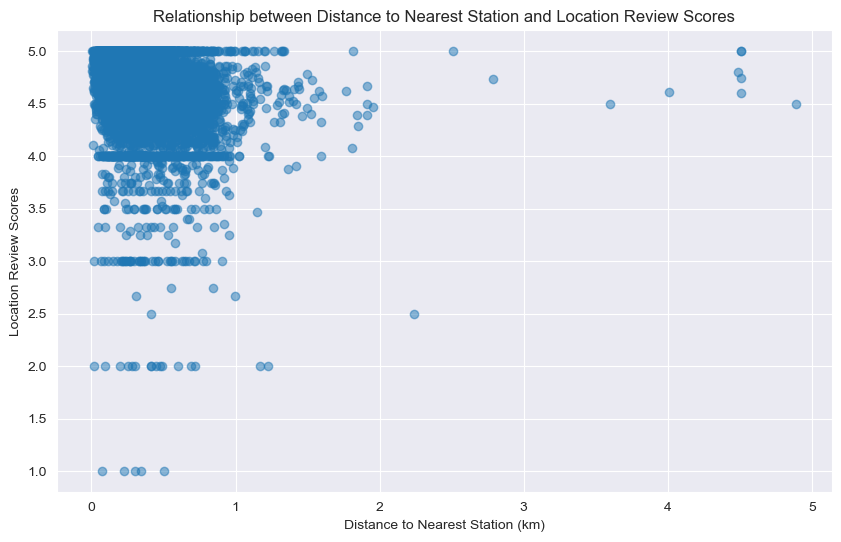

In [31]:
correlation = df_full['distance_to_station'].corr(df_full['review_scores_location'])
print(f"Correlation between distance to nearest station and location review scores: {correlation:.2f}")


plt.figure(figsize=(10, 6))
plt.scatter(df_full['distance_to_station'], df_full['review_scores_location'], alpha=0.5)
plt.title('Relationship between Distance to Nearest Station and Location Review Scores')
plt.xlabel('Distance to Nearest Station (km)')
plt.ylabel('Location Review Scores')
plt.grid(True)
plt.show()


The confidence interval does not contain 0, which means the negative correlation between distance to the nearest station and location review scores is statistically significant at the 95% confidence level.
Also, the interval is relatively narrow, which suggests a pretty high level of confidence in the correlation coefficient.

In [36]:
# Calculating the confidence interval for the correlation coefficient using Fisher's Z transformation
def get_confidence_interval(df):
    r = -0.25
    n = len(df)

    # Fisher's Z Transformation
    z = 0.5 * np.log((1 + r) / (1 - r))

    # Standard error of z
    SE_z = 1/np.sqrt(n-3)

    # 95% CI for z
    z_alpha_2 = 1.96  # for 95% CI
    z_lower = z - z_alpha_2 * SE_z
    z_upper = z + z_alpha_2 * SE_z

    # Transform z CI back to r
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)

    print(f"95% Confidence Interval for the correlation coefficient: ({r_lower:.3f}, {r_upper:.3f})")

get_confidence_interval(df_full['distance_to_station'])

95% Confidence Interval for the correlation coefficient: (-0.268, -0.232)


#### Calculate correlation coefficient for "Shi" and "Ku" separately

I calculated the correlation coefficient between location review score and distancet to the nearest station, separately for "Shi" and "Ku" to see if there is a difference between the two.
The correlation coefficient for "Shi" is -0.06, and the correlation coefficient for "Ku" is -0.24, which suggests that there is a stronger negative correlation. However, the number of listings in "Shi" is much smaller than the number of listings in "Ku", so the correlation coefficient for "Shi" is less reliable.

In [45]:
def calculate_correlation_for_area(df, area_type):
    df = df[df['neighbourhood_cleansed'].notna()]

    filtered_df = df[df['neighbourhood_cleansed'].str.endswith(area_type)]

    # Calculate the correlation coefficient
    correlation = filtered_df['distance_to_station'].corr(filtered_df['review_scores_location'])

    return correlation

# Calculate correlation for "Shi"
shi_correlation = calculate_correlation_for_area(df_full, "Shi")
print(f"Correlation for 'Shi' areas: {shi_correlation:.2f}")

# Calculate correlation for "Ku"
ku_correlation = calculate_correlation_for_area(df_full, "Ku")
print(f"Correlation for 'Ku' areas: {ku_correlation:.2f}")


Correlation for 'Shi' areas: -0.06
Correlation for 'Ku' areas: -0.24


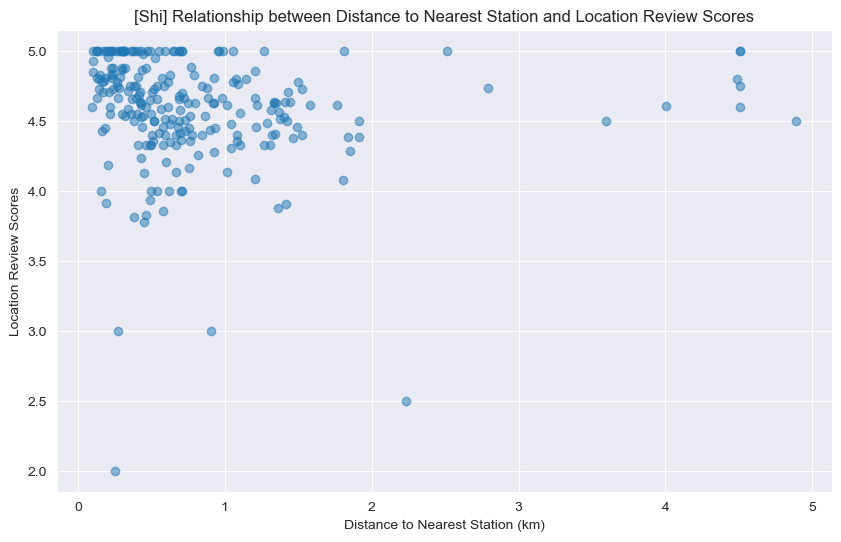

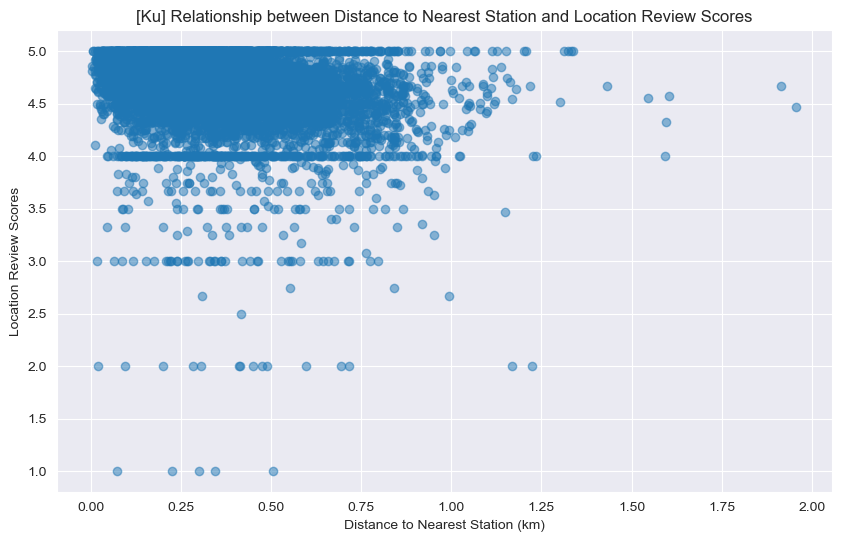

In [47]:
def scatter_plot(df, area_type):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['distance_to_station'], df['review_scores_location'], alpha=0.5)
    plt.title(f'[{area_type}] Relationship between Distance to Nearest Station and Location Review Scores'.format(area_type=area_type))
    plt.xlabel('Distance to Nearest Station (km)')
    plt.ylabel('Location Review Scores')
    plt.grid(True)
    plt.show()

# Scatter plot for "Shi"
shi_df = df_full[df_full['neighbourhood_cleansed'].str.endswith("Shi")]
scatter_plot(shi_df, "Shi")

# Scatter plot for "Ku"
shi_df = df_full[df_full['neighbourhood_cleansed'].str.endswith("Ku")]
scatter_plot(shi_df, "Ku")

### Relation between location and train line

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3488250533.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df_full.groupby('train_line').median()['review_scores_location'].sort_values(ascending=False).index


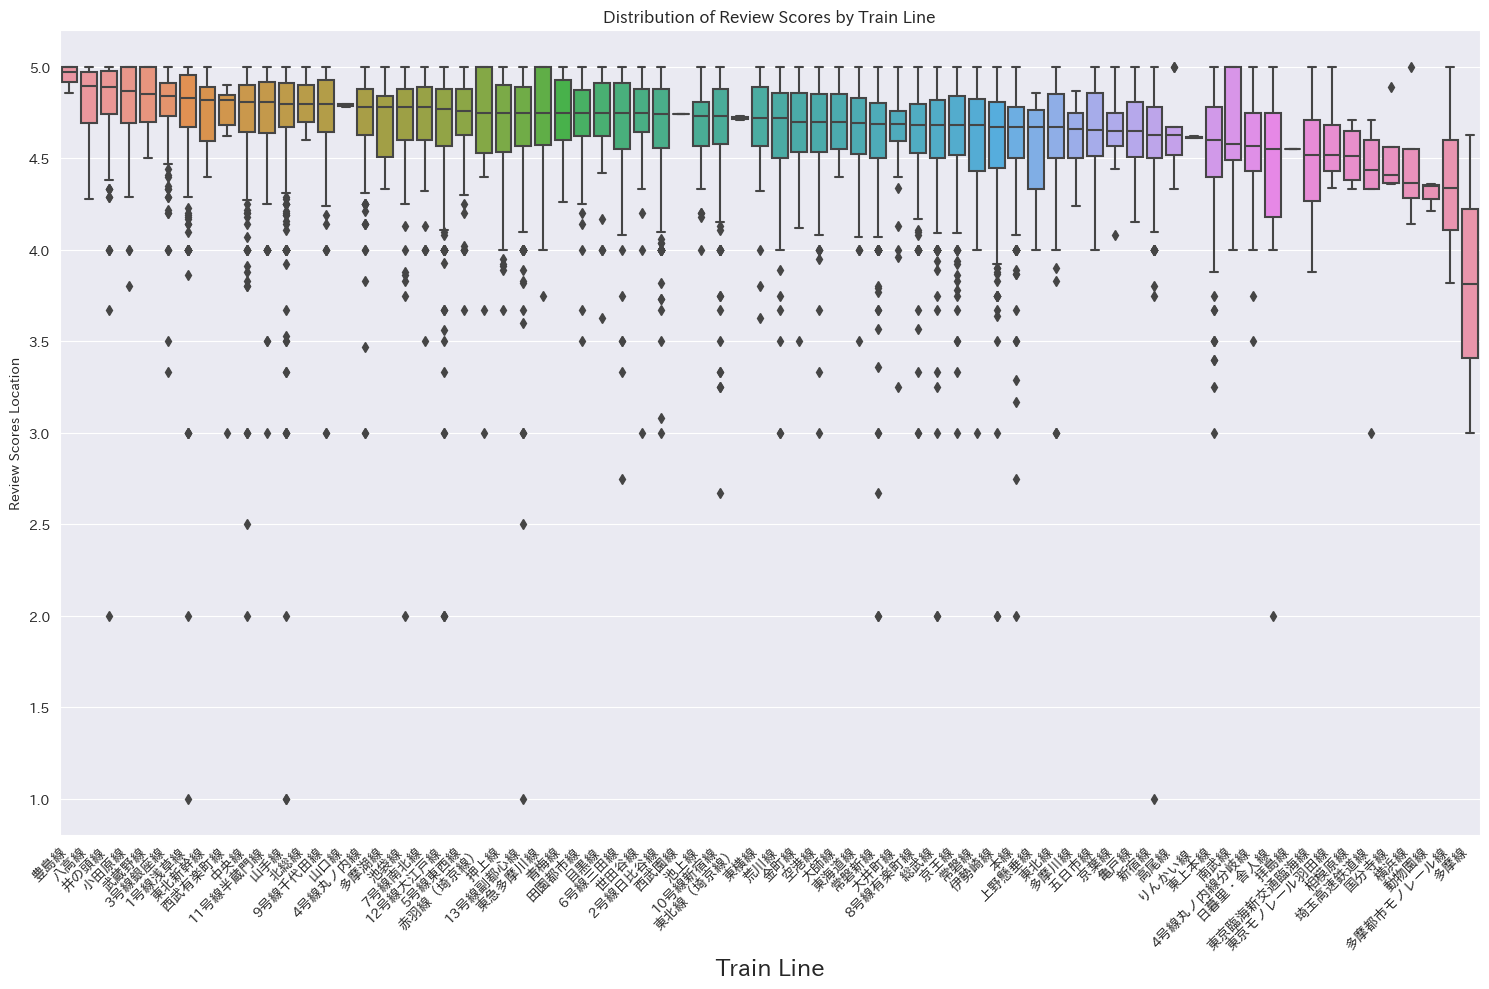

In [53]:
import japanize_matplotlib

plt.figure(figsize=(15, 10))
order = df_full.groupby('train_line').median()['review_scores_location'].sort_values(ascending=False).index
sns.boxplot(data=df_full, x='train_line', y='review_scores_location', order=order)

# Rotate x labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.title('Distribution of Review Scores by Train Line')
plt.xlabel('Train Line', fontsize=17)
plt.ylabel('Review Scores Location')

plt.tight_layout()
plt.show()

## Relation between location and nearest station

I created a boxplot of location review scores for each station. The stations are sorted by the median location review score.

The stations with the highest median location review scores can be classified into two groups:
1. Those close to northern Shinjuku, such as "Okubo", "Shin-Okubo", "Higashi-Shinjuku", "Nishi-Shinjuku-Gochome", "Ikebukuro", "Shimo-Ochiai".
2. Those close to Skytree/Asakusa, such as "Honjo-Azumabashi", "Asakusa", "Oshiage", "Iriya"


/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3684344762.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index


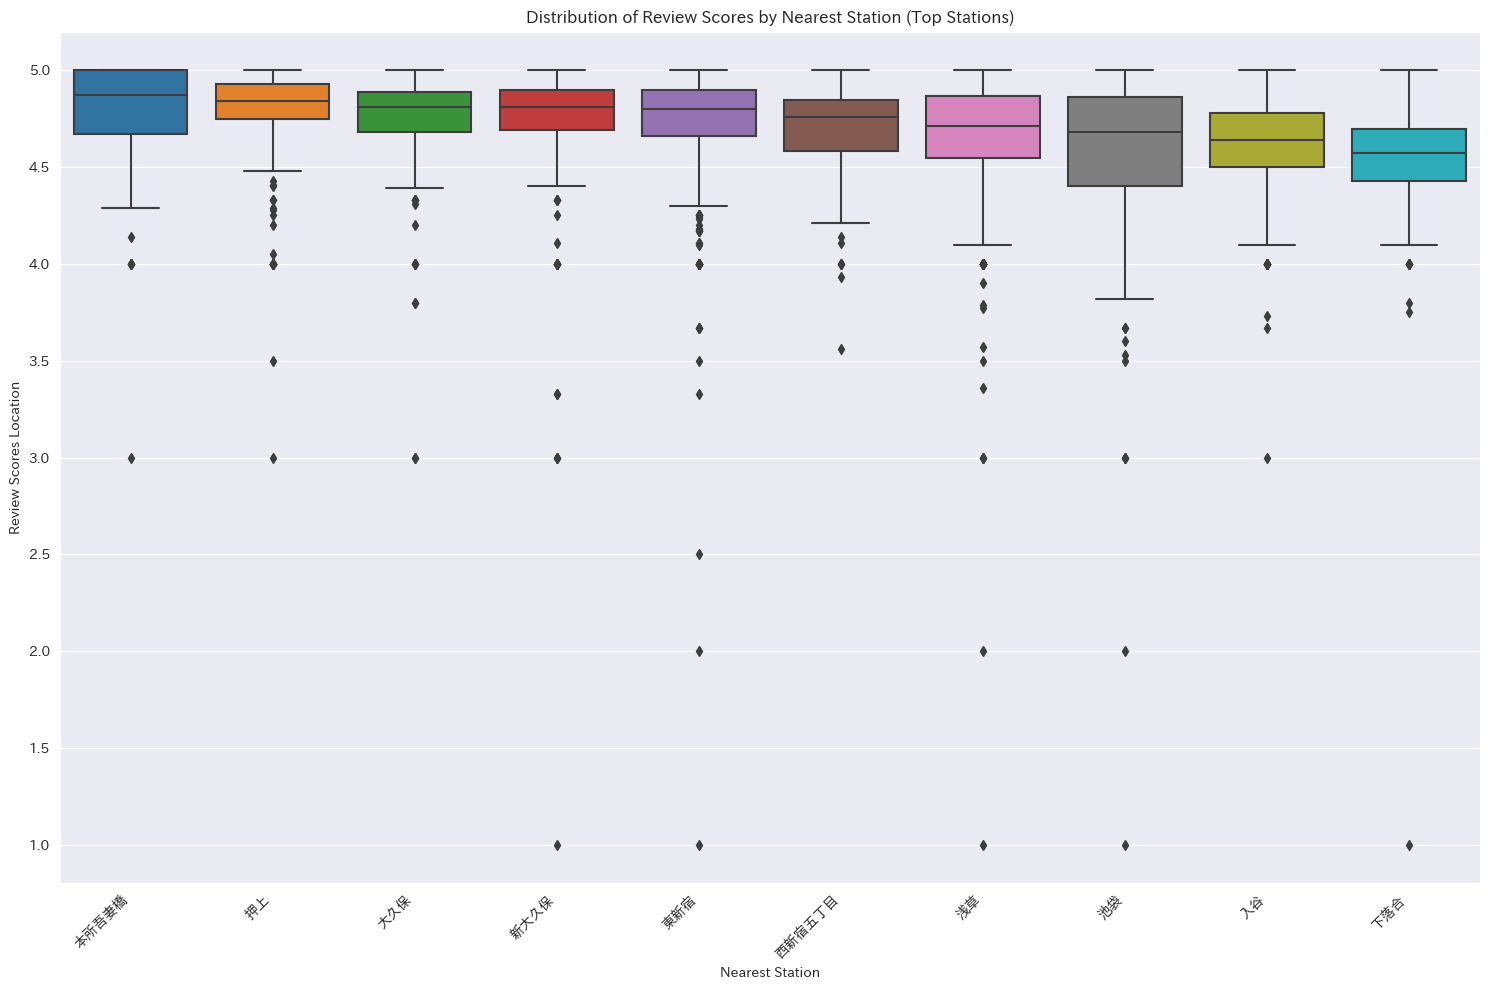

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3684344762.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index


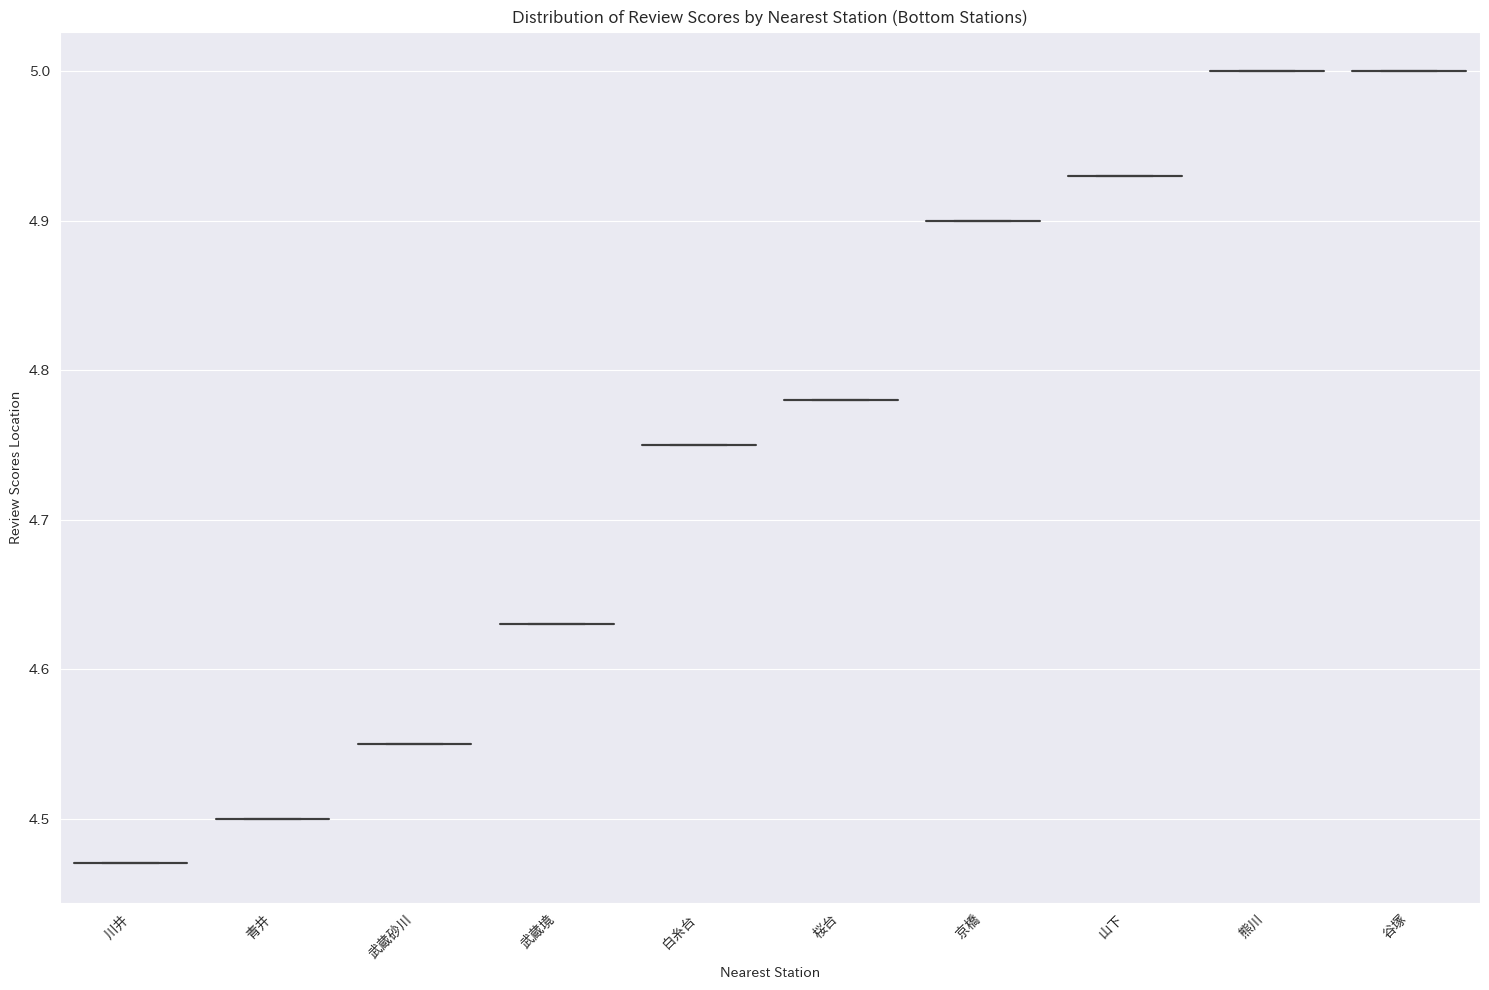

In [67]:
import japanize_matplotlib

def nearest_station_boxplot_by_station(df, ascending=True):
    if ascending:
        top_stations = df['nearest_station'].value_counts().head(10).index
        filtered_df = df[df['nearest_station'].isin(top_stations)]
    else:
        bottom_stations = df['nearest_station'].value_counts().tail(10).index
        filtered_df = df[df['nearest_station'].isin(bottom_stations)]

    plt.figure(figsize=(15, 10))
    order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index
    sns.boxplot(data=filtered_df, x='nearest_station', y='review_scores_location', order=order)

    plt.xticks(rotation=45, ha='right')

    label = 'Top' if ascending else 'Bottom'
    plt.title(f'Distribution of Review Scores by Nearest Station ({label} Stations)'.format(label=label))
    plt.xlabel('Nearest Station')
    plt.ylabel('Review Scores Location')

    plt.tight_layout()
    plt.show()

nearest_station_boxplot_by_station(df_full, ascending=True)
nearest_station_boxplot_by_station(df_full, ascending=False)